# Medical Knowledge Graph Visualization

In [7]:
import json
from pathlib import Path
import networkx as nx
import matplotlib.pyplot as plt
from pyvis.network import Network
import plotly.graph_objects as go
import plotly.express as px
from collections import Counter
import pandas as pd

# Load the knowledge graph
kg_path = Path("../../data/processed_enhanced/knowledge_graph.json")

with open(kg_path, 'r', encoding='utf-8') as f:
    kg_data = json.load(f)

print(f" Loaded Knowledge Graph")
print(f"   Entities: {kg_data.get('total_entities', 'N/A')}")
print(f"   Relations: {len(kg_data['relations'])}")
print(f"   Entity Types: {list(kg_data['entity_stats'].keys())}")

 Loaded Knowledge Graph
   Entities: N/A
   Relations: 174
   Entity Types: ['disease', 'biomarker', 'stage', 'detailed_description', 'disease_disorder', 'therapeutic_procedure', 'medication', 'date', 'diagnostic_procedure', 'lab_value', 'outcome', 'mechanism', 'quantitative_concept', 'sex', 'clinical_event', 'treatment', 'risk_factor', 'administration', 'sign_symptom', 'biological_structure', 'symptom', 'subject', 'activity', 'duration', 'history', 'protein', 'gene', 'coreference', 'brain_region', 'assessment', 'personal_background', 'age', 'family_history', 'severity', 'frequency', 'dosage', 'lifestyle', 'other_event', 'shape', 'time', 'nonbiological_location', 'qualitative_concept', 'protective_factor', 'other_entity', 'occupation', 'distance', 'volume', 'color', 'texture']


## 1. Entity Statistics

In [8]:
# Visualize entity distribution
entity_stats = kg_data['entity_stats']

fig = px.bar(
    x=list(entity_stats.keys()),
    y=list(entity_stats.values()),
    title="Medical Entity Distribution",
    labels={'x': 'Entity Type', 'y': 'Count'},
    color=list(entity_stats.values()),
    color_continuous_scale='Viridis'
)
fig.update_layout(height=500, showlegend=False)
fig.show()

# Print top entities by type
print("\n📊 Entity Breakdown:")
for entity_type, count in sorted(entity_stats.items(), key=lambda x: x[1], reverse=True):
    print(f"   {entity_type:20s}: {count:5d} unique entities")


📊 Entity Breakdown:
   diagnostic_procedure:  9103 unique entities
   detailed_description:  6009 unique entities
   sign_symptom        :  4884 unique entities
   lab_value           :  4612 unique entities
   medication          :  1727 unique entities
   disease_disorder    :  1420 unique entities
   coreference         :  1246 unique entities
   biological_structure:   948 unique entities
   therapeutic_procedure:   612 unique entities
   history             :   459 unique entities
   date                :   321 unique entities
   subject             :   306 unique entities
   activity            :   294 unique entities
   nonbiological_location:   293 unique entities
   duration            :   258 unique entities
   family_history      :   252 unique entities
   clinical_event      :   187 unique entities
   dosage              :   151 unique entities
   age                 :   136 unique entities
   quantitative_concept:    92 unique entities
   severity            :    80 uniqu

## 2. Relation Type Distribution

In [9]:
# Analyze relation types
relations = kg_data['relations']
relation_types = Counter([r['relation'] for r in relations])

fig = px.pie(
    names=list(relation_types.keys()),
    values=list(relation_types.values()),
    title="Relation Type Distribution"
)
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.show()

print("\n🔗 Relation Types:")
for rel_type, count in relation_types.most_common():
    print(f"   {rel_type:20s}: {count:4d} relations")


🔗 Relation Types:
   causes              :   66 relations
   associated_with     :   59 relations
   improves            :   16 relations
   reduces             :   16 relations
   prevents            :   11 relations
   treats              :    5 relations
   increases_risk      :    1 relations


## 3. Interactive Network Graph (Sample)

**Note**: Visualizing all 34K entities would be too dense. We'll show a filtered sample.

In [10]:
# Create interactive network with pyvis (sample of high-confidence relations)
net = Network(height='750px', width='100%', bgcolor='#222222', font_color='white', notebook=False)
net.barnes_hut(gravity=-8000, central_gravity=0.3, spring_length=200)

# Filter to high-confidence relations only
relations = kg_data['relations']
high_conf_relations = [r for r in relations if r.get('confidence', 0) >= 0.7]

# Limit to first 100 relations for visualization
sample_relations = high_conf_relations[:100]

# Color mapping for relation types
relation_colors = {
    'treats': '#00ff00',
    'causes': '#ff0000',
    'associated_with': '#ffff00',
    'improves': '#00ffff',
    'reduces': '#ff00ff',
    'prevents': '#00ff88',
    'increases_risk': '#ff8800',
    'indicated_for': '#0088ff',
    'correlates_with': '#88ff00'
}

nodes_added = set()

if not sample_relations:
    print("⚠️ No high-confidence relations to visualize.")
else:
    # Add nodes and edges
    for rel in sample_relations:
        source = rel['source']
        target = rel['target']
        rel_type = rel['relation']
        confidence = rel.get('confidence', 0.5)
        
        # Add source node
        if source not in nodes_added:
            net.add_node(source, label=source[:30], title=source, color='#97c2fc')
            nodes_added.add(source)
        
        # Add target node
        if target not in nodes_added:
            net.add_node(target, label=target[:30], title=target, color='#fb7e81')
            nodes_added.add(target)
        
        # Add edge
        edge_color = relation_colors.get(rel_type, '#888888')
        net.add_edge(
            source, 
            target, 
            title=f"{rel_type} (conf: {confidence:.2f})",
            color=edge_color,
            width=confidence * 3
        )

    # Save and display
    output_file = "knowledge_graph_interactive.html"
    try:
        net.show(output_file, notebook=False)
    except Exception as e:
        print(f"\n⚠️ PyVis show() failed: {e}. Falling back to write_html.")
        net.write_html(output_file, notebook=False)
    
    print(f"\n✅ Interactive graph saved to: {output_file}")
    print(f"   Nodes: {len(nodes_added)}")
    print(f"   Edges: {len(sample_relations)}")
    print(f"\n🌐 Open {output_file} in your browser to explore!")

knowledge_graph_interactive.html

✅ Interactive graph saved to: knowledge_graph_interactive.html
   Nodes: 163
   Edges: 100

🌐 Open knowledge_graph_interactive.html in your browser to explore!

✅ Interactive graph saved to: knowledge_graph_interactive.html
   Nodes: 163
   Edges: 100

🌐 Open knowledge_graph_interactive.html in your browser to explore!


## 4. Static Network Graph (NetworkX)

C:\Users\lando\AppData\Local\Temp\ipykernel_37452\1344801207.py:30: UserWarning:

Glyph 120573 (\N{MATHEMATICAL ITALIC SMALL BETA}) missing from font(s) DejaVu Sans.

c:\Bureau\projet_Dl\Projet-DL-Big-Data-\backend\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning:

Glyph 120573 (\N{MATHEMATICAL ITALIC SMALL BETA}) missing from font(s) DejaVu Sans.

c:\Bureau\projet_Dl\Projet-DL-Big-Data-\backend\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning:

Glyph 120573 (\N{MATHEMATICAL ITALIC SMALL BETA}) missing from font(s) DejaVu Sans.



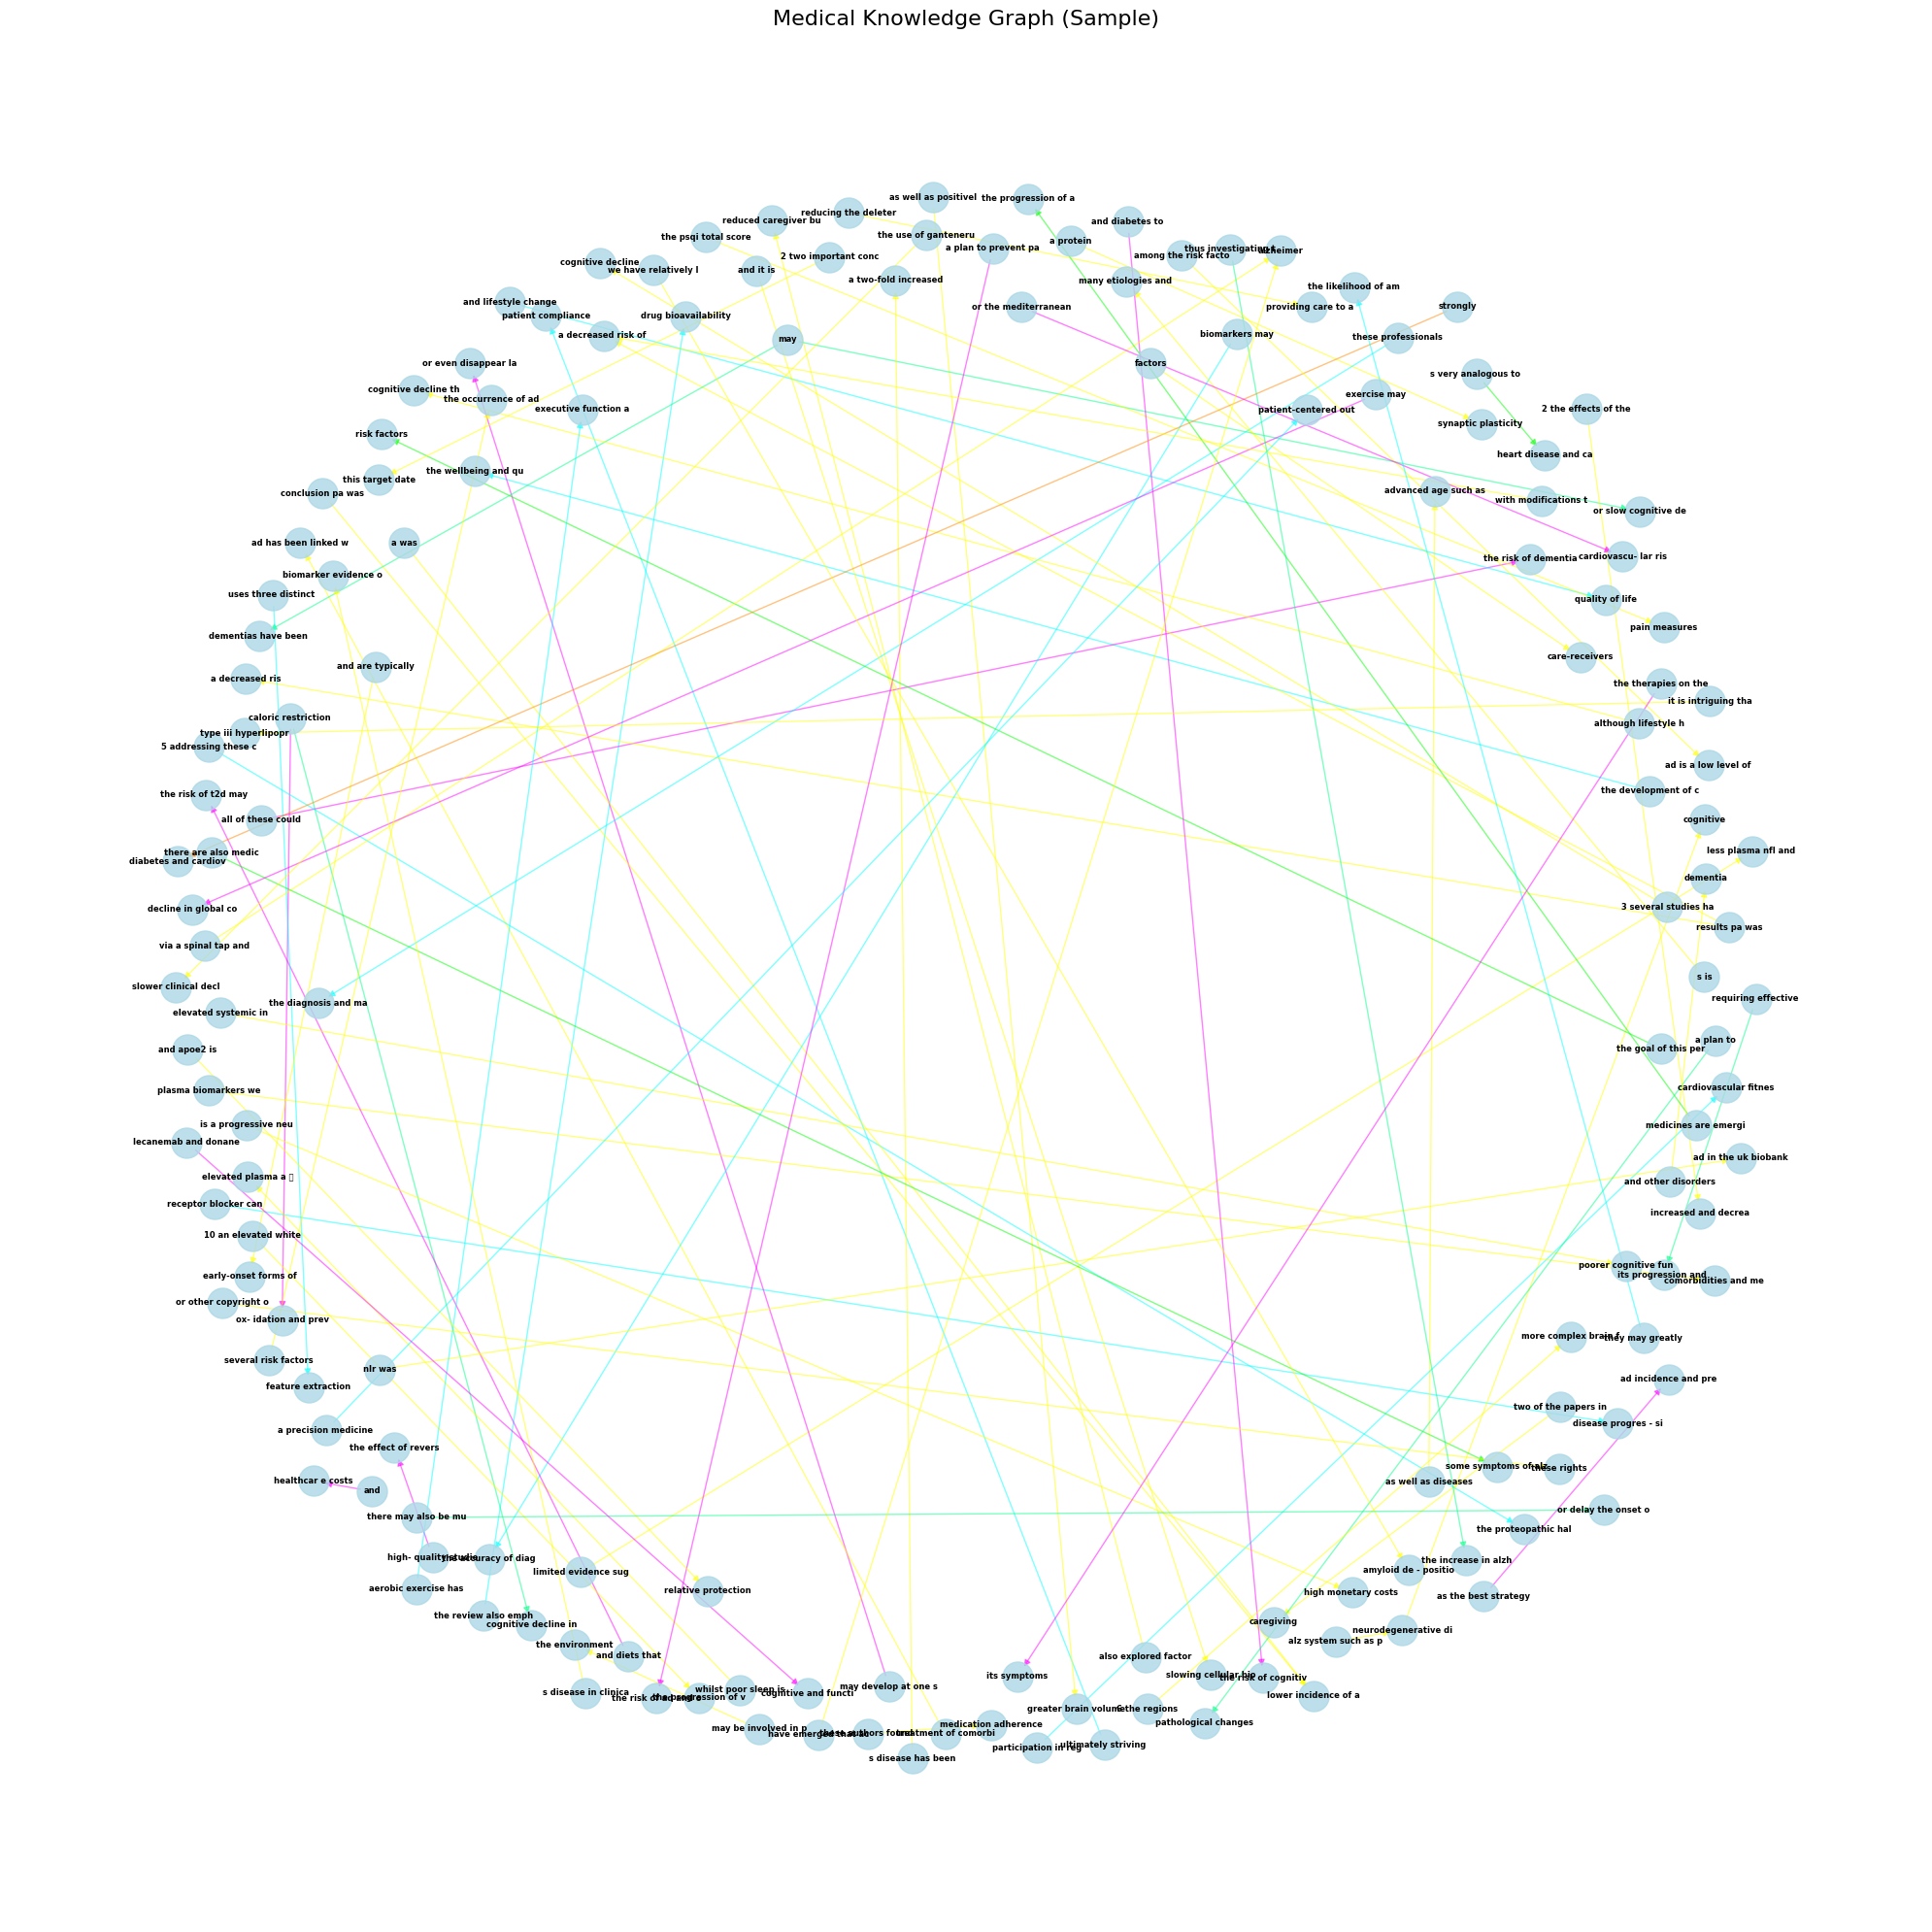

✅ Static graph saved to: knowledge_graph_static.png


In [11]:
# Create a static network graph
G = nx.DiGraph()

# Use same sample as above
for rel in sample_relations:
    G.add_edge(
        rel['source'][:20], 
        rel['target'][:20], 
        relation=rel['relation'],
        confidence=rel.get('confidence', 0.5)
    )

# Draw the graph
plt.figure(figsize=(20, 20))
pos = nx.spring_layout(G, k=2, iterations=50)

# Draw nodes
nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=500, alpha=0.8)

# Draw edges with different colors by relation type
edge_colors = [relation_colors.get(G[u][v]['relation'], '#888888') for u, v in G.edges()]
nx.draw_networkx_edges(G, pos, edge_color=edge_colors, alpha=0.5, arrows=True, arrowsize=10)

# Draw labels (smaller font)
nx.draw_networkx_labels(G, pos, font_size=6, font_weight='bold')

plt.title("Medical Knowledge Graph (Sample)", fontsize=16)
plt.axis('off')
plt.tight_layout()
plt.savefig('knowledge_graph_static.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Static graph saved to: knowledge_graph_static.png")

## 5. Top Entities by Type

In [12]:
# Show top entities for each category
entities = kg_data['entities']

print("\n🏥 Top Medical Entities by Category:\n")

for entity_type, entity_list in entities.items():
    print(f"\n{entity_type.upper()} (showing top 10):")
    print("-" * 60)
    for i, entity in enumerate(entity_list[:10], 1):
        print(f"  {i:2d}. {entity}")


🏥 Top Medical Entities by Category:


DISEASE (showing top 10):
------------------------------------------------------------
   1. memory impairment
   2. parkinson's
   3. frontotemporal
   4. parkinson
   5. alzheimer
   6. lewy body
   7. progressive supranuclear palsy
   8. alzheimer's
   9. huntington
  10. creutzfeldt-jakob

BIOMARKER (showing top 10):
------------------------------------------------------------
   1. fdg-pet
   2. plasma biomarker
   3. phosphorylated tau
   4. apoe4
   5. aβ42
   6. amyloid
   7. nfl
   8. t-tau
   9. csf
  10. cerebrospinal fluid

STAGE (showing top 10):
------------------------------------------------------------
   1. late-onset
   2. preclinical
   3. early-onset
   4. severe
   5. prodromal
   6. advanced
   7. terminal
   8. young-onset
   9. sporadic
  10. familial

DETAILED_DESCRIPTION (showing top 10):
------------------------------------------------------------
   1. erative
   2. phase 3 randomised controlled trials
   3. iating
   

## 7. Relation Confidence Analysis

In [13]:
# Analyze confidence scores
confidences = [r.get('confidence', 0.5) for r in relations]

fig = go.Figure()
fig.add_trace(go.Histogram(
    x=confidences,
    nbinsx=20,
    marker_color='indianred',
    opacity=0.7
))

fig.update_layout(
    title="Relation Confidence Distribution",
    xaxis_title="Confidence Score",
    yaxis_title="Count",
    height=400
)
fig.show()

print(f"\n📊 Confidence Statistics:")
print(f"   Mean: {sum(confidences)/len(confidences):.3f}")
print(f"   Min:  {min(confidences):.3f}")
print(f"   Max:  {max(confidences):.3f}")
print(f"   High confidence (≥0.8): {sum(1 for c in confidences if c >= 0.8)} relations")


📊 Confidence Statistics:
   Mean: 0.690
   Min:  0.600
   Max:  0.800
   High confidence (≥0.8): 48 relations


## 8. Sample Queries on Knowledge Graph

In [14]:
# Example: Find all treatments
print("\n💊 Sample Query: What treats Alzheimer's?\n")

treatments = []
for rel in relations:
    if rel['relation'] == 'treats' and 'alzheimer' in rel['target'].lower():
        treatments.append((rel['source'], rel.get('confidence', 0)))

# Sort by confidence
treatments.sort(key=lambda x: x[1], reverse=True)

for i, (treatment, conf) in enumerate(treatments[:10], 1):
    print(f"  {i:2d}. {treatment:40s} (confidence: {conf:.2f})")

# Example: Find risk factors
print("\n⚠️  Sample Query: What increases risk of Alzheimer's?\n")

risk_factors = []
for rel in relations:
    if rel['relation'] == 'increases_risk' and 'alzheimer' in rel['target'].lower():
        risk_factors.append((rel['source'], rel.get('confidence', 0)))

risk_factors.sort(key=lambda x: x[1], reverse=True)

for i, (risk, conf) in enumerate(risk_factors[:10], 1):
    print(f"  {i:2d}. {risk:40s} (confidence: {conf:.2f})")


💊 Sample Query: What treats Alzheimer's?

   1. medicines are emerging to                (confidence: 0.80)
   2. there are also medicines available to    (confidence: 0.80)

⚠️  Sample Query: What increases risk of Alzheimer's?

